# Deciphering handwritten digits without nets

It is well known that neural networks have been extremenly succesful at cracking problems previously thought to be untractable. 
The recently announced google assistant's ability to book restaurants and hairdresser appointments is just the last on the list of the numerous achievements of neural networks. In this blog post, I want to emphasize the fact that deep learning is not always a necessity and often nearly as precise predictions can be achieved with simpler, more transparent and less computationally expensive algorithms. To this end we will try to crack handwritten digits recognition without neural networks.
We will use the MNIST database, a well known and extensively used database of handwritten digits. You can download it here: <http://yann.lecun.com/exdb/mnist/>. On the same site, the performance of different classifiers is reported, including neural nets. So, clearly what I will illustrate in this blog post is not new (this is usually the case in machine learning), but still worth my time (and I hope yours).   

## Python, get the data!

The MNIST database is so popular that it comes with the `sklearn` module of python. To get it, I just need to call the function `fetch_mldata`:

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home="./")

This downloads the data in the specified local path, as a .mat file, and loads it into the python environment. The images are 70000, with a resolution of 28x28 pixels, ready to go into a machine learning pipeline. Here a few examples:

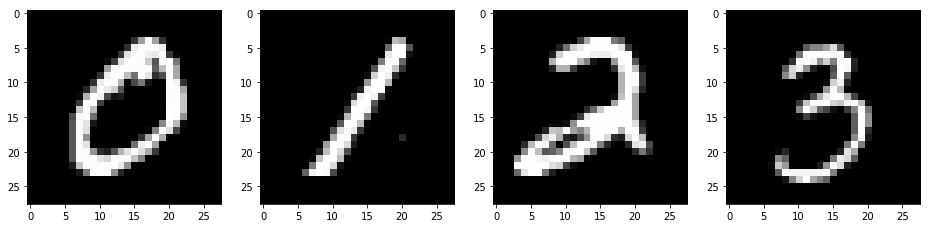

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4));

# image 0
plt.subplot(1, 4, 1);
plt.imshow(mnist.data[0].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));

# image 1
plt.subplot(1, 4, 2);
plt.imshow(mnist.data[10000].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));

# image 2
plt.subplot(1, 4, 3);
plt.imshow(mnist.data[15000].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));

# image 3
plt.subplot(1, 4, 4);
plt.imshow(mnist.data[20000].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));

## Pre-processing

The database is clean, in the sense that all elements are handwritten digits. So we do not have to worry about data cleaning, often considered to be 80% of the data scientist's job. Instead, we can directly start pre-processing.

### Traininig and testing

The first step is to divide the data into training and test sets. As their names suggest, the former is used to train predictive models, whereas the latter is used to test their performance. Even better practice would be to use k-fold validation: divide the dataset into k equally sized subsets, and train k different models, each tested with a different subset. The final model is the average of those. The clear advantage of this method is that the resulting model generalizes better: its predictions are better with new data. However, it is time consuming and not necessary for this blog's post purposes. 

For us, a good compromise is to keep 60000 images in the training set and 10000 images in the test set. We can do this using the `train_test_split` function of `sklearn`:

In [5]:
from sklearn.model_selection import train_test_split
# divide the data into train and test sets, with a proportion of 6:1
train_img, test_img, train_lbl, test_lbl = train_test_split(mnist.data, 
                                                            mnist.target, 
                                                            test_size=1/7.0,
                                                            random_state=0)

### Rescaling

Next, we have to rescale the feature vectors. This is a very important step as it can increase dramatically the performance of the classifier. 
The function `StandardScaler` of `sklearn` does so by subtracting from each vector the mean and dividing by the standard deviation of the train dataset:

In [6]:
from sklearn.preprocessing import StandardScaler
import warnings; warnings.simplefilter('ignore')

scaler = StandardScaler()
# Fit on training set only
scaler.fit(train_img)
# Apply transform to both the training set and the test set
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

### Dimensionality reduction

Before feeding the data to our favourite machine learning algorithms, there is a last step that can help achieve better performance. The images come as vectors of dimension 784, so already as respectable feature vectors. However, it could be that not all of these dimensions contain relevant information. For instance, the pixels in the corners are likely to always be empty, as the figures above show. To avoid carrying over unnecessary information we can use Principal Component Analysis, a technique well known in statistical analysis that roughly consists in finding a rotation in the feature vectors' space such that the variance of the data projected into the first principal component is maximal, and decreases monothonically for all other principal components. 
As you might have guessed, `sklearn` has a function for that. As an argument to the function, it is possible to state the amount of the variance (i.e. information) that we want to keep in our feature vectors. We will try different options: 95%, 90% and 50% of the variance.

In [7]:
from sklearn.decomposition import PCA
# apply PCA with different variance thresholds
pca95 = PCA(.95)
pca95.fit(train_img)

pca90 = PCA(.90)
pca90.fit(train_img)

pca50 = PCA(.50)
pca50.fit(train_img)

pca95_train_img = pca95.transform(train_img)
pca95_test_img = pca95.transform(test_img)

pca90_train_img = pca90.transform(train_img)
pca90_test_img = pca90.transform(test_img)

pca50_train_img = pca50.transform(train_img)
pca50_test_img = pca50.transform(test_img)

[pca95.n_components_, pca90.n_components_, pca50.n_components_]

[330, 236, 39]

It turns out that 95% of the information is contained in only 330 dimensions, 90% in 236 and 50% in 39! It is important to notice that the results of Principal Component Analysis are not independent of the rescaling: applying PCA before or after rescaling, or rescaling differently, would have given different results. However, it is a great tool for feature preparation, if used responsibly. 
Now let's illustrate the effect of PCA by plotting the same image before and after these transformations. To do this, we need to rotate the feature vectors back to their original axes and revert the scaling:

In [10]:
res95_train_img = pca95.inverse_transform(pca95_train_img)
res90_train_img = pca90.inverse_transform(pca90_train_img)
res50_train_img = pca50.inverse_transform(pca50_train_img)

res95_train_img = scaler.inverse_transform(res95_train_img)
res90_train_img = scaler.inverse_transform(res90_train_img)
res50_train_img = scaler.inverse_transform(res50_train_img)

res100_train_img = scaler.inverse_transform(train_img)

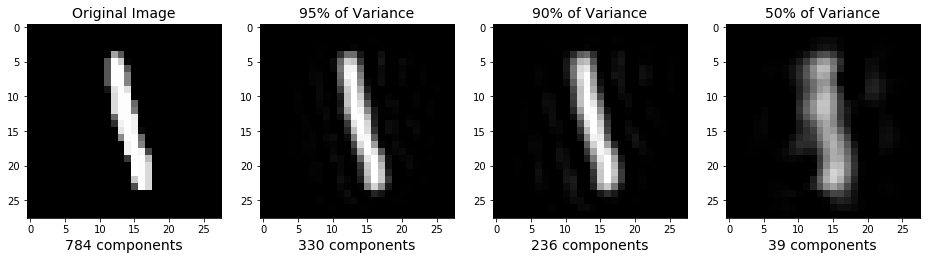

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4));

# Original Image
plt.subplot(1, 4, 1);
plt.imshow(res100_train_img[1].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 14);

# 330 principal components
plt.subplot(1, 4, 2);
plt.imshow(res95_train_img[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('330 components', fontsize = 14)
plt.title('95% of Variance', fontsize = 14);

# 236 principal components
plt.subplot(1, 4, 3);
plt.imshow(res90_train_img[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('236 components', fontsize = 14)
plt.title('90% of Variance', fontsize = 14);

# 39 principal components
plt.subplot(1, 4, 4);
plt.imshow(res50_train_img[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('39 components', fontsize = 14)
plt.title('50% of Variance', fontsize = 14);

As expected, leaving out information leads to increasingly blurred images.

Another way to illustrate the effect of PCA is to look at the scatter plot of the different digits in feature space, before and after the rotation to the principal compenents. Using  the `seaborn` and `pandas` modules, we can conveniently gather the data into a single dataframe and plot it as follows:

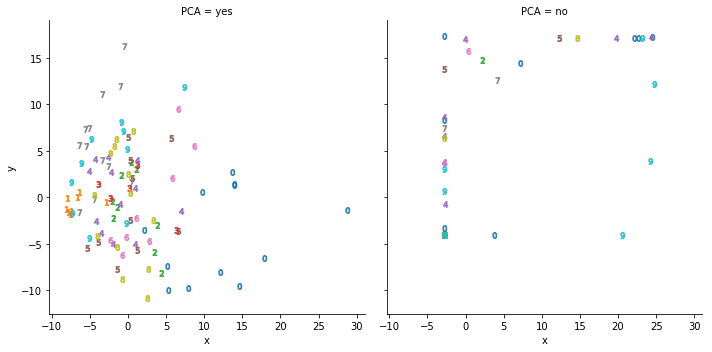

In [12]:
import seaborn as sns
import pandas as pd

rng = list(range(99))
mrks = ["$0$", "$1$", "$2$", "$3$", "$4$", "$5$", "$6$", "$7$", "$8$", "$9$"]

df1 = pd.DataFrame({"x" : pca95_train_img[rng,0],
                    "y" : pca95_train_img[rng,1],
                    "label" : train_lbl[rng],
                    "PCA" : "yes"})
df2 = pd.DataFrame({"x" : 7.5*train_img[rng,370],
                    "y" : 7.5*train_img[rng,371],
                    "label" : train_lbl[rng],
                    "PCA" : "no"})

df_plot = pd.concat([df1, df2])

plot = sns.lmplot(x="x", 
                  y="y",  
                  data=df_plot, 
                  fit_reg=False, 
                  hue='label', 
                  markers=mrks, 
                  legend = False,
                  col="PCA")

The plot on the left shows the first two principal components, which account for nearly 10% of the total variance. Compared to the plot on the right, that shows two central pixels of the original feature vectors (rescaled for illustration purposes), it is striking that after PCA, the feature vectors seem to occupy more uniformly the feature space. Also, already with 10% of the variance, we can distinguish the zeros on the lower right corner, and the sevens in the upper left corner.

## Learning to distinguish digits

We are now ready to train some models for handwritten digits recognition. The aim isn't to come up with the best performance, but rather to show that surprisingly good performance can be attained with very little effort. We will use 4 different models: logistic regression, random forest, support vector machine and gradient boosting machine. 

### Logistic regression

Simpler things first. Logistic regression is a very simple classification algorithm and probably the first one should try. Let us train classifiers with the previously prepared feature vectors: do we need 100% of the information or do we get better performance leaving some combination of pixels out? 

In [26]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'

lr1 = LogisticRegression(solver = 'lbfgs')
lr1.fit(train_img, train_lbl)
lr100 = lr1.score(test_img, test_lbl)

lr2 = LogisticRegression(solver = 'lbfgs')
lr2.fit(pca95_train_img, train_lbl)
lr95 = lr2.score(pca95_test_img, test_lbl)

lr3 = LogisticRegression(solver = 'lbfgs')
lr3.fit(pca90_train_img, train_lbl)
lr90 = lr3.score(pca90_test_img, test_lbl)

lr4 = LogisticRegression(solver = 'lbfgs')
lr4.fit(pca50_train_img, train_lbl)
lr50 = lr4.score(pca50_test_img, test_lbl)

In [27]:
df_lr = pd.DataFrame({"% of variance" : [100, 95, 90, 50],
                      "dimension of feature vector" : [784, pca95.n_components_, pca90.n_components_, pca50.n_components_],
                      "performance" : [lr100, lr95, lr90, lr50]})

df_lr

,% of variance,dimension of feature vector,performance
0,100,784,0.9157
1,95,330,0.9201
2,90,236,0.9168
3,50,39,0.8861


The table above summarizes our findings. All models are close to 90% accuracy, a very good result given the amount of effort that we put in. Keeping 95% of the variance gives the best performance, with 92% accuracy. This proves the usefulness of Principal Component analysis: it can help train models that generalise better. 

### K-nearest neighbours

K-nearest neighbours (knn) is another simple algorithm that deserves a try early in the model building process. It works by assigning a new data point to the class that is most common amongst its k nearest neighbours. In its simplest form, the k neighbours are assigned the same weighting and the distance is computed using the euclidean metric in feature space. But all these are hyperparameters that one could fit to improve the model's performance. Here, we choose to consider 5 neighbours with equal weights:

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(train_img, train_lbl)
knn100 = knn1.score(test_img, test_lbl)

knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(pca95_train_img, train_lbl)
knn95 = knn2.score(pca95_test_img, test_lbl)

knn3 = KNeighborsClassifier(n_neighbors=5)
knn3.fit(pca90_train_img, train_lbl)
knn90 = knn3.score(pca90_test_img, test_lbl)

knn4 = KNeighborsClassifier(n_neighbors=5)
knn4.fit(pca50_train_img, train_lbl)
knn50 = knn4.score(pca50_test_img, test_lbl)

In [30]:
df_knn = pd.DataFrame({"% of variance" : [100, 95, 90, 50],
                       "dimension of feature vector" : [784, pca95.n_components_, pca90.n_components_, pca50.n_components_],
                       "performance" : [knn100, knn95, knn90, knn50]})

df_knn

,% of variance,dimension of feature vector,performance
0,100,784,0.9481
1,95,330,0.9497
2,90,236,0.9535
3,50,39,0.9592


As can be seen in the table above, knn also benefits from feature preparation with PCA. In fact, the best performing model is the one trained with only 50% of the information, and performs quite well, at nearly 96% accuracy! 

### Random forest

Random forest is a very popular algorithm. Its name derives from the fact that it trains a collection of decision trees, each trained with a different subset of the training set and of the feature vectors. It is a very robust model, that does the feature selection for you. For this reason, PCA is less useful in this case, but let's see if nevertheless it allows to improve the model's performance:

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(max_features=35, max_depth=1000, random_state=0)
rf1.fit(train_img, train_lbl)
rf100 = rf1.score(test_img, test_lbl)

rf2 = RandomForestClassifier(max_features=35, max_depth=1000, random_state=0)
rf2.fit(pca95_train_img, train_lbl)
rf95 = rf2.score(pca95_test_img, test_lbl)

rf3 = RandomForestClassifier(max_features=35, max_depth=1000, random_state=0)
rf3.fit(pca90_train_img, train_lbl)
rf90 = rf3.score(pca90_test_img, test_lbl)

rf4 = RandomForestClassifier(max_features=35, max_depth=1000, random_state=0)
rf4.fit(pca50_train_img, train_lbl)
rf50 = rf4.score(pca50_test_img, test_lbl)

In [32]:
df_rf = pd.DataFrame({"% of variance" : [100, 95, 90, 50],
                          "dimension of feature vector" : [784, pca95.n_components_, pca90.n_components_, pca50.n_components_],
                          "performance" : [rf100, rf95, rf90, rf50]})

df_rf

,% of variance,dimension of feature vector,performance
0,100,784,0.9514
1,95,330,0.9048
2,90,236,0.9129
3,50,39,0.9174


As anticipated, PCA does not help with improving the model here. The good news is that we reach over 95% accuracy without even doing a PCA! That is one of the biggest strengths of random forests: they generalize very well, with little effort. 

### Support vector machine

Support vector machine (SVM) is based on geometric considerations: it identifies classes regions in feature space based on the notion of maximal distance between classes. Using suitable chosen kernel functions, it is possible to identify non-linearly separated classes and even classes in an infinite space. 
Let's see how PCA affects the SVM classifier:

In [33]:
from sklearn import svm

clf1 = svm.SVC()
clf1.fit(train_img, train_lbl)
svm100 = clf1.score(test_img, test_lbl)

clf2 = svm.SVC()
clf2.fit(pca95_train_img, train_lbl)
svm95 = clf2.score(pca95_test_img, test_lbl)

clf3 = svm.SVC()
clf3.fit(pca90_train_img, train_lbl)
svm90 = clf3.score(pca90_test_img, test_lbl)

clf4 = svm.SVC()
clf4.fit(pca50_train_img, train_lbl)
svm50 = clf4.score(pca50_test_img, test_lbl)

In [34]:
df_svm = pd.DataFrame({"% of variance" : [100, 95, 90, 50],
                          "dimension of feature vector" : [784, pca95.n_components_, pca90.n_components_, pca50.n_components_],
                          "performance" : [svm100, svm95, svm90, svm50]})

df_svm

,% of variance,dimension of feature vector,performance
0,100,784,0.9642
1,95,330,0.9619
2,90,236,0.9597
3,50,39,0.8945


The best performing model is the one trained with all the information, with over 96% accuracy. This is a great result, considering that we used the defaults hyperparamenters of SVM. Tuning them, would presumably considerably increase the performance. Furthermore, PCA does not seem to help: the less information we keep, the worst the perfomance, although it does not decrease by much between 100%, 95% and 90%. Such small differences are not conclusive: perhaps with new data, things would change. 

### Gradient boosting machine

Gradient boosting machine (gbm) is a relatively new and really cool learning algorithm. It's strategy relies on minizing the prediction errors (residuals) by fitting first a simple model to the data, such as a logistic regression, and then fitting another model to the residuals of the first model, that is the difference between predictions and ground truth. Then, the sum of these two models is taken and the previous step is repeated. This process goes on until the residuals stop improving: no meaningful pattern can be fit to them. Given the complexity of this model, it usually takes a while to train and does not benefit much from PCA. For these reasons I decided to train the model only once, with the full feature vectors. I will the `XGBClassifier` from `xgboost`, a version of gbm optimized for performance. Let's see:

In [35]:
from xgboost import XGBClassifier

# fit model no training data
xgb = XGBClassifier()
xgb.fit(train_img, train_lbl)
xgb100 = xgb.score(test_img, test_lbl)

In [36]:
xgb100

0.9339

We get nearly 93.4% accuracy, not the best score so far but still pretty good. The `XGBClassifier` default settings use a decision tree model to fit the data and residuals, with specific choices of many parameters. So, presumably there is still a large margin of improvement!

## Putting it all together

Let's summarize our findings in a single table:

In [96]:
df_sum = pd.DataFrame({"% of variance" : [100, 95, 90, 50],
                       "dimension of feature vector" : [784, pca95.n_components_, pca90.n_components_, pca50.n_components_],
                       "logistic regression" : [lr100, lr95, lr90, lr50],
                       "k-nearest neighbours" : [knn100, knn95, knn90, knn50],
                       "random forest" : [rf100, rf95, rf90, rf50],
                       "support vector machine" : [svm100, svm95, svm90, svm50],
                       "gradient boosting machine" : [xgb100, "--", "--", "--"]})

df_sum

,% of variance,dimension of feature vector,gradient boosting machine,k-nearest neighbours,logistic regression,random forest,support vector machine
0,100,784,0.9339,0.9481,0.9157,0.9514,0.1029
1,95,330,--,0.9497,0.9201,0.9048,0.9619
2,90,236,--,0.9535,0.9168,0.9129,0.9597
3,50,39,--,0.9592,0.8861,0.9174,0.8945


The best performing model is SVM with the full feature vectors. But this does not tell us much since we did not really try to optimize all these models. The takehome message is that we can go a long way with little effort.

A benchmark to assess these models is to compare them to a human's performance. So let's have a look at some of the errors that our best model did:

In [119]:
df_predict = pd.DataFrame({"predicted" : clf1.predict(test_img),
                           "actual" : test_lbl})

incorrect = df_predict[df_predict["actual"] != df_predict["predicted"]]

# transform the test images back to their original form
test_img = scaler.inverse_transform(test_img)

In [118]:
test_img = scaler.transform(test_img)

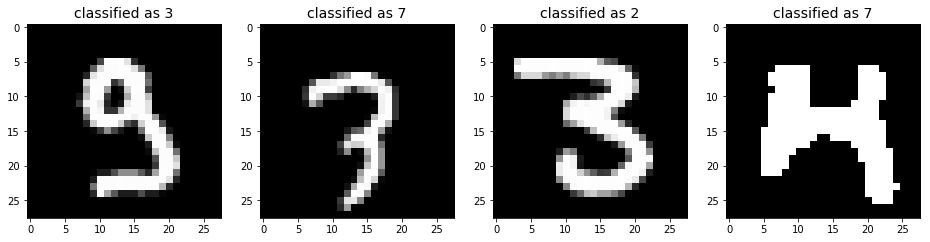

In [120]:
import warnings; warnings.simplefilter('ignore')
plt.figure(figsize=(16,4));

# image 0
plt.subplot(1, 4, 1);
plt.imshow(test_img[incorrect.index.values[0]].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('classified as ' + str(int(incorrect["predicted"][[incorrect.index.values[0]]])), fontsize = 14);

# image 1
plt.subplot(1, 4, 2);
plt.imshow(test_img[incorrect.index.values[1]].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('classified as ' + str(int(incorrect["predicted"][[incorrect.index.values[1]]])), fontsize = 14);

# image 2
plt.subplot(1, 4, 3);
plt.imshow(test_img[incorrect.index.values[2]].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('classified as ' + str(int(incorrect["predicted"][[incorrect.index.values[2]]])), fontsize = 14);

# image 3
plt.subplot(1, 4, 4);
plt.imshow(test_img[incorrect.index.values[3]].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('classified as ' + str(int(incorrect["predicted"][[incorrect.index.values[3]]])), fontsize = 14);

Arguably a human would still do a better job than our best model. But keep in mind that we did not try very hard to optimize the model, so perhaps we could eventually get better than the average human... 

And, it seems svm has an issue with 7s! How many digits are wrongly assigned to 7, or other numbers?

In [139]:
df_error_shares = pd.DataFrame({"as 0" : round(incorrect[incorrect["predicted"] == 0].shape[0]/incorrect.shape[0],3),
                                "as 1" : round(incorrect[incorrect["predicted"] == 1].shape[0]/incorrect.shape[0],3),
                                "as 2" : round(incorrect[incorrect["predicted"] == 2].shape[0]/incorrect.shape[0],3),
                                "as 3" : round(incorrect[incorrect["predicted"] == 3].shape[0]/incorrect.shape[0],3),
                                "as 4" : round(incorrect[incorrect["predicted"] == 4].shape[0]/incorrect.shape[0],3),
                                "as 5" : round(incorrect[incorrect["predicted"] == 5].shape[0]/incorrect.shape[0],3),
                                "as 6" : round(incorrect[incorrect["predicted"] == 6].shape[0]/incorrect.shape[0],3),
                                "as 7" : round(incorrect[incorrect["predicted"] == 7].shape[0]/incorrect.shape[0],3),
                                "as 8" : round(incorrect[incorrect["predicted"] == 8].shape[0]/incorrect.shape[0],3),
                                "as 9" : round(incorrect[incorrect["predicted"] == 9].shape[0]/incorrect.shape[0],3)},
                              index=[0])

df_error_shares                 

,as 0,as 1,as 2,as 3,as 4,as 5,as 6,as 7,as 8,as 9
0,0.045,0.05,0.134,0.123,0.098,0.07,0.089,0.198,0.101,0.092


So 7 is the most common mistake, accounting for nearly 20% of errors. 0, 1 and 5 are the less common. 

Finally, which numbers does the model mostly get woring?

In [140]:
df_error_shares = pd.DataFrame({"as 0" : round(incorrect[incorrect["actual"] == 0].shape[0]/incorrect.shape[0],3),
                                "as 1" : round(incorrect[incorrect["actual"] == 1].shape[0]/incorrect.shape[0],3),
                                "as 2" : round(incorrect[incorrect["actual"] == 2].shape[0]/incorrect.shape[0],3),
                                "as 3" : round(incorrect[incorrect["actual"] == 3].shape[0]/incorrect.shape[0],3),
                                "as 4" : round(incorrect[incorrect["actual"] == 4].shape[0]/incorrect.shape[0],3),
                                "as 5" : round(incorrect[incorrect["actual"] == 5].shape[0]/incorrect.shape[0],3),
                                "as 6" : round(incorrect[incorrect["actual"] == 6].shape[0]/incorrect.shape[0],3),
                                "as 7" : round(incorrect[incorrect["actual"] == 7].shape[0]/incorrect.shape[0],3),
                                "as 8" : round(incorrect[incorrect["actual"] == 8].shape[0]/incorrect.shape[0],3),
                                "as 9" : round(incorrect[incorrect["actual"] == 9].shape[0]/incorrect.shape[0],3)},
                              index=[0])

df_error_shares   

,as 0,as 1,as 2,as 3,as 4,as 5,as 6,as 7,as 8,as 9
0,0.034,0.078,0.087,0.154,0.092,0.14,0.047,0.095,0.103,0.17


The most difficult digits to classify are 9, 3 and 8. We could continue investigating, but I think we already covered enough for today!

## Conclusions

We have seen how five different learning algorithms without nets can do a good job at identigying handwriten digits. Two of them, logistic regression and knn, benefit from a preliminary PCA applied to the feature vectors, whereas the others, random forest, svm and gbm, give the best results on the full feature vectors. Our best model is svm with full features, at 96.42% accuracy. Optimization could bring this up to 99.44%, as documented <a href="http://yann.lecun.com/exdb/mnist/">here</a>. With neural networks, the accuracy can be as high as 99.65%, presumably with a considerable effort.

## Acknowledgements

The inspiration to write this post came to me while reading <a href="http://neuralnetworksanddeeplearning.com/index.html">Michael Nielsen's online book on neural networks</a>. He uses the MNIST database to train a neural network, mentioning that good results can be achieved with other learning algorithms also. This triggered my curiosity, so I dug deeper and ended up writing this post. I also borrowed some ideas from <a href="https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60">here</a>, particularly concerning the visualisation of PCA's effect on the digits. 